In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
from joblib import load
from datetime import datetime, timezone
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import ipywidgets as widgets
from ipywidgets import interact, fixed
from sklearn.metrics import r2_score
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src import plotting

In [2]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')
all_test_df = pd.read_csv(f'{data_dir}/p.test.csv')
all_holdout_df = pd.read_csv(f'{data_dir}/p.20230101.csv')

In [3]:
model_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_models/selected_features_constHP'
preds_2023 = pd.read_csv(os.path.join(model_dir, 'YDC.P.preds.holdout.csv'))
scaler = load(os.path.join(model_dir, 'YDC.P.scaler.joblib'))

In [4]:
cat = pd.read_csv("../../data/catalogs/yellowstone.events.2024.csv")
cat.head()

,evid,event_lat,event_lon,event_depth,origin_time,magnitude,magnitude_type,rflag,utc
0,60000005,44.743333,-111.067500,5.48,1.349112e+09,-0.20,d,F,2012-10-01 17:26:54.360001+00:00
1,60000010,44.438167,-111.032000,6.05,1.349101e+09,0.35,d,F,2012-10-01 14:24:40.459999+00:00
2,60000050,44.276000,-110.645667,2.18,1.350621e+09,1.15,d,F,2012-10-19 04:29:58.239998+00:00
3,60000060,44.346167,-110.327333,9.44,1.350808e+09,1.34,d,F,2012-10-21 08:32:33.660000+00:00
4,60000065,44.395000,-111.021833,4.71,1.350274e+09,0.82,d,F,2012-10-15 04:14:30.209999+00:00


In [5]:
stat = "YDC"
proc = GatherFeatureDatasets(is_p=True)
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        test_df=all_test_df,
                                                                                        holdout_df=all_holdout_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YDC
X shape: (2928, 45), y shape: (2928,)
X shape: (725, 45), y shape: (725,)
X shape: (29, 45), y shape: (29,)


In [6]:
feature_plot_names = proc.get_feature_plot_names(18, 'dist')

In [7]:
selected_features = np.array(['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg'])
feature_inds = np.where(np.isin(feature_names, selected_features))[0]

In [8]:
X_train = station_feature_dict['X_train']
X_holdout = station_feature_dict['X_holdout']

In [9]:
SMALL_SIZE=8
MEDIUM_SIZE=9
LARGE_SIZE=9
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=MEDIUM_SIZE)

In [10]:
train_cat = cat[cat["evid"].isin(station_meta_dict["evids_train"])]
test_cat = cat[cat["evid"].isin(station_meta_dict["evids_test"])]
holdout_cat = cat[cat["evid"].isin(station_meta_dict["evids_holdout"])]
assert train_cat.shape[0] == station_meta_dict["evids_train"].shape[0]
assert np.array_equal(train_cat.evid.values, station_meta_dict["evids_train"])
assert test_cat.shape[0] == station_meta_dict["evids_test"].shape[0]
assert np.array_equal(test_cat.evid.values, station_meta_dict["evids_test"])
assert holdout_cat.shape[0] == station_meta_dict["evids_holdout"].shape[0]
assert np.array_equal(holdout_cat.evid.values, station_meta_dict["evids_holdout"])

In [11]:
X_train_s = scaler.transform(X_train[:, feature_inds])
X_holdout_s = scaler.transform(X_holdout[:, feature_inds])

In [12]:
all_X = np.concatenate([X_train[:, :], X_holdout[:, :]])
all_X_s = np.concatenate([X_train_s[:, :], X_holdout_s[:, :]])
all_y = np.concatenate([station_meta_dict['y_train'], station_meta_dict['y_holdout']])
all_ot = np.concatenate([train_cat["origin_time"].values,
                holdout_cat["origin_time"].values])
print(all_X.shape, all_y.shape, all_ot.shape)

(2957, 45) (2957,) (2957,)


In [13]:
model = load(os.path.join(model_dir, 'YDC.P.SVR.joblib'))
X_test_s = scaler.transform(station_feature_dict["X_test"][:, feature_inds])

# Interactive plots

In [14]:
# Generate random 3D data points
def plot_3d_scatter(z_feature, scale_X=True, elev=10, azim=-110):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax2 = fig.add_subplot(1, 10, (10, 10))

    cmap = plt.get_cmap('viridis')
    bounds = np.arange(2013, 2024)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    mags=all_y
    if scale_X:
        X = all_X_s
        srdist_ind = np.where(feature_names[feature_inds] == "source_receiver_distance_logkm")[0][0]
        z_feature_ind = np.where(feature_names[feature_inds] == z_feature)[0][0]
    else:
        X = all_X
        srdist_ind = np.where(feature_names == "source_receiver_distance_logkm")[0][0]
        z_feature_ind = np.where(feature_names == z_feature)[0][0]

    # print(srdist_ind, z_feature_ind)
    srdists=X[:, srdist_ind]
    ots = all_ot
    z = X[:, z_feature_ind]

    # Create the scatter plot
    sc = ax.scatter(mags, srdists, z, c=ots, cmap=cmap, s=15, edgecolor='k')
    
    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a color bar to show how colors map to z values
    #fig.colorbar(sc, ax=ax, label=labels[3])
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, extend="max", label="OT Year")
             
    # Set axis labels
    ax.set_xlabel("Mag")
    ax.set_ylabel("source_receiver_dist_logkm")
    ax.set_zlabel(z_feature)

    plt.show()

# Use ipywidgets interact function to make the plot interactive
interact(plot_3d_scatter,
         z_feature=feature_names[feature_inds],
         scaled_X=True,
         elev=widgets.FloatSlider(min=-180, max=180, step=1, value=10, description='Elevation'),
         azim=widgets.FloatSlider(min=-180, max=180, step=1, value=-110, description='Azimuth'));


interactive(children=(Dropdown(description='z_feature', options=('amp_1', 'amp_2', 'signal_variance', 'noise_v…

In [15]:

def plot_2d_scatter(x_feat="ot", y_feat="mag", color_feat="signal_variance"):

    if x_feat == "mag":
        x = all_y
        x_label = "$M_{L,YP21}$"
    elif x_feat == "ot":
        x = mdates.date2num(pd.to_datetime(all_ot, unit="s"))
        x_label = "Origin Time"

    if y_feat == "mag":
        y = all_y
        y_label = "$M_{L,YP21}$"
    else:
        y_feat_ind = np.where(feature_names[feature_inds] == y_feat)[0][0]
        y = all_X_s[:, y_feat_ind]
        y_label = feature_plot_names[np.where(feature_names == y_feat)[0]][0]

    cmap = matplotlib.colormaps["viridis"]

    format = None
    if color_feat == "mag":
        c = all_y
        c_label = "$M_{L,YP21}$"
    elif color_feat == "ot":
        c = mdates.date2num(pd.to_datetime(all_ot, unit="s"))
        c_label = "Origin Time"
        format = DateFormatter('%Y')
    else:
        c_feat_ind = np.where(feature_names[feature_inds] == color_feat)[0][0]
        c = all_X_s[:, c_feat_ind]
        c_label = feature_plot_names[np.where(feature_names == color_feat)[0]][0]

    fig, ax = plt.subplots(1)
    s = ax.scatter(x,
                  y,
                  c=c,
                  cmap=cmap
                )

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    cb = fig.colorbar(s, label=c_label, format=format)

    if x_feat == "ot":
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

interact(plot_2d_scatter,
         x_feat=["mag", "ot"],
         y_feat=["mag", *selected_features],
         color_feat=["mag", "ot", *selected_features],
        );


interactive(children=(Dropdown(description='x_feat', index=1, options=('mag', 'ot'), value='ot'), Dropdown(des…

# Binned plots

In [16]:
def mag_year_bin_stats(X, y, ot, feature_ind):
    starttime = datetime(2013, 1, 1, tzinfo=timezone.utc).timestamp()
    summary = []
    for i, year in enumerate(range(2014, 2025)):
        endtime = datetime(year, 1, 1, tzinfo=timezone.utc).timestamp()
        # print(starttime, endtime)
        year_inds = np.where((ot >= starttime) & (ot < endtime))[0]
        year_filt_X = X[year_inds, feature_ind:feature_ind+1]
        year_filt_y = y[year_inds]
        startmag = 0.0
        for endmag in np.arange(0.5, 5.0, 0.5):
            mag_inds = np.where((year_filt_y >= startmag) & (year_filt_y < endmag))[0]
            if len(mag_inds) < 2:
                startmag=endmag
                q1, median, q3, mean = np.nan, np.nan, np.nan, np.nan
            else:  
                pos = (endmag+startmag)/2
                #print(startmag, endmag, pos)   
                q1, median, q3 = np.quantile(year_filt_X[mag_inds, :], [0.25, 0.5, 0.75])
                mean = np.mean(year_filt_X[mag_inds, :])
            summary.append([starttime, endtime, startmag, endmag, q1, median, q3, mean, len(mag_inds)])
            startmag=endmag
        starttime = endtime
    df = pd.DataFrame(summary, columns=["start_time", "end_time", "start_mag", "end_mag", "q1", "median", "q3", "mean", "N"])
    return df

In [17]:
year_mag_bin_dict = {}
for feature_name in [*selected_features, "amp_ratio_1", "amp_ratio_2"]:
    ind = np.where(feature_names == feature_name)[0][0]
    
    df = mag_year_bin_stats(all_X, all_y, all_ot, ind)
    year_mag_bin_dict[feature_name] = {"plot_name":feature_plot_names[ind],
                                       "ind":ind,
                                       "df":df
                                        }
    if feature_name in selected_features:
        scaled_ind = np.where(feature_names[feature_inds] == feature_name)[0][0]
        scaled_df = mag_year_bin_stats(all_X_s, all_y, all_ot, scaled_ind)
        year_mag_bin_dict[f"scaled_{feature_name}"] = {"plot_name":f"scaled {feature_plot_names[ind]}",
                                                        "scaled_ind":scaled_ind,
                                                        "df":scaled_df
                                                        }

Text(0, 0.5, 'Number of examples (training ex. only before 2023)')

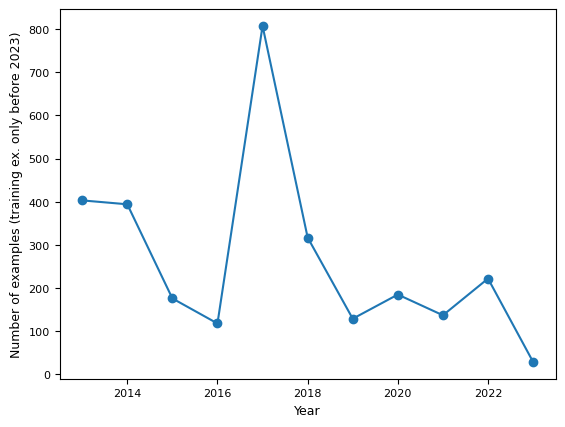

In [18]:
## 2017 had the Maple Creek Sequence
year_cnts = df.groupby("start_time")["N"].sum().reset_index()
plt.plot(year_cnts.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                   tz=timezone.utc).year, axis=1), 
         year_cnts["N"], marker="o")
plt.xlabel("Year")
plt.ylabel("Number of examples (training ex. only before 2023)")

In [19]:
def plot_amp_and_snr(amp_feature_name, sr_feature_name, binstartmags):
    amp_df = year_mag_bin_dict[amp_feature_name]["df"]
    sr_df = year_mag_bin_dict[sr_feature_name]["df"]
    amp_label = year_mag_bin_dict[amp_feature_name]["plot_name"]
    sr_label = year_mag_bin_dict[sr_feature_name]["plot_name"]
    for startmag in binstartmags:     
        fig, ax = plt.subplots(1, 2,
                        constrained_layout=True,
                        figsize=(8, 4))
        fig.suptitle(f"M {startmag} - {startmag + 0.5}")
        startmag_df = amp_df[amp_df["start_mag"] == startmag]  
        print(startmag, startmag_df.iloc[-1]["N"])      
        ax[0].plot(startmag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                        tz=timezone.utc).year, axis=1),
                    startmag_df["median"],
                    c="k",
                    marker='o')
        ax[0].errorbar(startmag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                        tz=timezone.utc).year, axis=1),
                    startmag_df["median"],
                    abs(startmag_df[["median", "median"]] - startmag_df[["q1", "q3"]].values).values.T,
                    color="k", 
                    capsize=10)
        
        
        srdist_startmag_df = sr_df[sr_df["start_mag"] == startmag]  
        ax[1].plot(srdist_startmag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                        tz=timezone.utc).year, axis=1),
                    srdist_startmag_df["median"],
                    c="k",
                    marker='o')
        ax[1].errorbar(srdist_startmag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                        tz=timezone.utc).year, axis=1),
                    srdist_startmag_df["median"],
                    abs(srdist_startmag_df[["median", "median"]] - srdist_startmag_df[["q1", "q3"]].values).values.T,
                    color="k", 
                    capsize=10)
        ax[1].set_ylabel(f"Median {sr_label}")
        ax[0].set_xlabel("OT Year")
        ax[0].set_ylabel(f"Median {amp_label}")

1.5 10.0
2.0 11.0


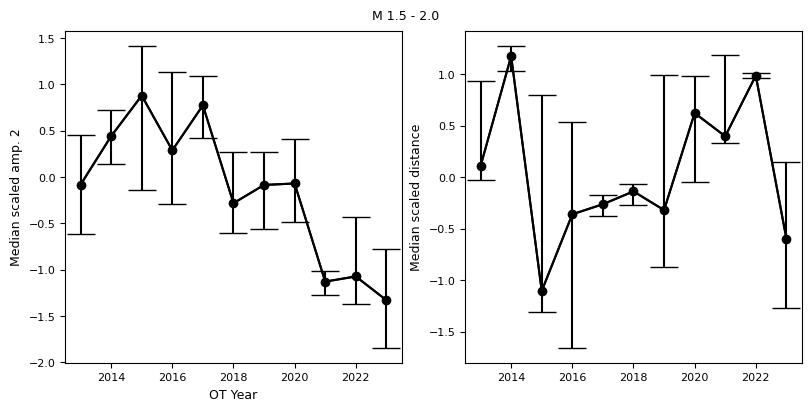

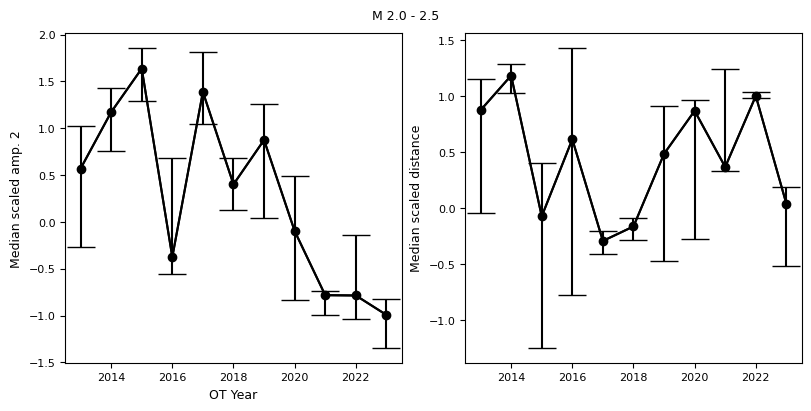

In [20]:
plot_amp_and_snr("scaled_amp_2", 
                 "scaled_source_receiver_distance_logkm", 
                 [1.5, 2.0])

In [21]:
# Scaled feature as a function of time
def plot_mag_binned(y_feature="scaled_amp_2", start_mags="2023", use_mean=True):
    cmap = matplotlib.colormaps["viridis"]
    color_bounds = np.arange(0.0, 5.0, 0.5)
    norm = matplotlib.colors.BoundaryNorm(color_bounds, cmap.N, extend='both')
    
    df = year_mag_bin_dict[y_feature]["df"]
    y_label = year_mag_bin_dict[y_feature]["plot_name"]
    if start_mags == "all":
        start_mags = df["start_mag"].unique()
    elif start_mags == "2023":
        start_mags = df[(df["start_time"] == 1672531200.0) & 
                        (~np.isnan(df["mean"]))]["start_mag"].values
    metric = "mean"
    if not use_mean:
        metric = "median"

    fig, ax = plt.subplots(1, 2,
                        width_ratios=[0.95, 0.05])
    print("2023 counts")
    for startmag in start_mags:     
        startmag_df = df[df["start_mag"] == startmag]  
        cmap_input = (startmag_df.iloc[0]["end_mag"]+startmag_df.iloc[0]["start_mag"])/2
        print(startmag, startmag_df.iloc[-1]["N"])       
        ax[0].plot(startmag_df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                        tz=timezone.utc).year, axis=1),
                    startmag_df[metric],
                    c=cmap(norm(cmap_input)),
                    marker='o')

    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax[1], extend='max', label="$M_{L,YP21}$"
                )

    ax[0].set_xlabel("Origin Time (Year)")
    ax[0].set_ylabel(f"{metric} {y_label}")

In [22]:
interact(plot_mag_binned,
         y_feature=year_mag_bin_dict.keys(),
         start_mags=["all", "2023"],
         use_mean=True)

interactive(children=(Dropdown(description='y_feature', index=3, options=('amp_1', 'scaled_amp_1', 'amp_2', 's…

<function __main__.plot_mag_binned(y_feature='scaled_amp_2', start_mags='2023', use_mean=True)>

In [23]:
# Scaled features by magnitude bin
def plot_mag_binned_y(y_feature="scaled_amp_2", start_mags="2023", use_mean=True):
    cmap = matplotlib.colormaps["viridis"]
    color_bounds = np.arange(2013, 2024)
    norm = matplotlib.colors.BoundaryNorm(color_bounds, cmap.N, extend='both')
    
    df = year_mag_bin_dict[y_feature]["df"]
    y_label = year_mag_bin_dict[y_feature]["plot_name"]

    if start_mags == "2023":
        df = df[df["start_mag"].isin(df[(df["start_time"] == 1672531200.0) 
                                        & (~np.isnan(df["mean"]))]["start_mag"])]
    metric = "mean"
    if not use_mean:
        metric = "median"

    fig, ax = plt.subplots(1, 2,
                        width_ratios=[0.95, 0.05])


    ax[0].scatter((df["end_mag"]+df["start_mag"])/2,
                    df["mean"],
                c=df.apply(lambda x: datetime.fromtimestamp(x["start_time"], 
                                    tz=timezone.utc).year, axis=1),
                cmap=cmap)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax[1], extend="max", label="OT Year"
                )

    ax[0].set_xlabel("$M_{L,YP21}$")
    ax[0].set_ylabel(f"{metric} {y_label}")

interact(plot_mag_binned_y,
         y_feature=year_mag_bin_dict.keys(),
         start_mags=["all", "2023"],
         use_mean=True)

interactive(children=(Dropdown(description='y_feature', index=3, options=('amp_1', 'scaled_amp_1', 'amp_2', 's…

<function __main__.plot_mag_binned_y(y_feature='scaled_amp_2', start_mags='2023', use_mean=True)>

# Plot $R^2$ values as a function of time

In [24]:
def compute_r2_v_time(cat, X, ds_type):
    starttime = datetime(2013, 1, 1, tzinfo=timezone.utc).timestamp()
    summary = []
    for i, year in enumerate(range(2014, 2024)):
        endtime = datetime(year, 1, 1, tzinfo=timezone.utc).timestamp()
        inds = np.where((cat["origin_time"] >= starttime) & (cat["origin_time"] < endtime))[0]
        assert np.array_equal(cat["evid"].iloc[inds], station_meta_dict[f"evids_{ds_type}"].iloc[inds])
        y_year_preds = model.predict(X[inds, :])
        summary.append([year-1, 
                        r2_score(station_meta_dict[f"y_{ds_type}"][inds],
                                    y_year_preds), 
                        len(inds)])
        starttime = endtime

    return pd.DataFrame(summary, columns=["year", "r2", "N"])


In [25]:
test_r2s = compute_r2_v_time(test_cat, X_test_s, "test")
train_r2s = compute_r2_v_time(train_cat, X_train_s, "train")

Text(0, 0.5, 'Number of Examples')

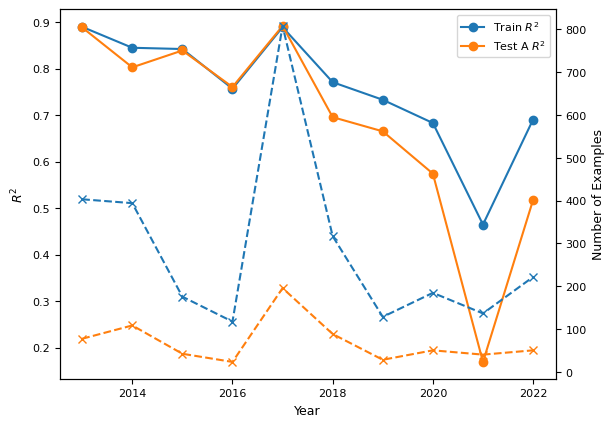

In [26]:
fig, ax = plt.subplots(1)

ax.plot(train_r2s["year"], train_r2s["r2"], marker="o", label="Train $R^2$")
ax.plot(test_r2s["year"], test_r2s["r2"], marker="o", label="Test A $R^2$")

ax2 = ax.twinx()

ax2.plot(train_r2s["year"], train_r2s["N"], marker="x", linestyle="--", label="Train N")
ax2.plot(test_r2s["year"], test_r2s["N"], marker="x", linestyle="--", label="Test A N")

# plt.plot(2023, 
#          r2_score(preds_2023["magnitude"], 
#                         preds_2023["predicted_magnitude"]),
#          marker="o",
#          label="Test B")
ax.legend()
ax.set_ylabel("$R^2$")
ax.set_xlabel("Year")
ax2.set_ylabel("Number of Examples")

In [59]:
train_r2s[train_r2s.year.isin([2021, 2022])]["N"].sum() / train_r2s["N"].sum()

0.12430747922437674

In [60]:
test_r2s[test_r2s.year.isin([2021, 2022])]["N"].sum() / test_r2s["N"].sum()

0.12939521800281295

In [41]:
train_resid_years = train_cat[train_cat["evid"].isin(station_meta_dict["evids_train"].iloc[np.where(abs(model.predict(X_train_s) - station_meta_dict["y_train"]) > 0.5)[0]])].apply(lambda x: datetime.fromtimestamp(x["origin_time"], tz=timezone.utc).year, axis=1).value_counts().reset_index()

In [46]:
train_resid_years["percent"] = train_resid_years["count"] / train_resid_years["count"].sum()

In [52]:
train_resid_years.sort_values("index")

,index,count,percent
8,2013,4,0.027397
2,2014,18,0.123288
9,2015,3,0.020548
7,2016,6,0.041096
5,2017,8,0.054795
4,2018,14,0.095890
6,2019,7,0.047945
3,2020,16,0.109589
1,2021,34,0.232877
0,2022,36,0.246575


In [54]:
(34+36)/train_resid_years["count"].sum()

0.4794520547945205

In [50]:
test_resid_years = test_cat[test_cat["evid"].isin(station_meta_dict["evids_test"].iloc[np.where(abs(model.predict(X_test_s) - station_meta_dict["y_test"]) > 0.5)[0]])].apply(lambda x: datetime.fromtimestamp(x["origin_time"], tz=timezone.utc).year, axis=1).value_counts().reset_index()
test_resid_years["percent"] = test_resid_years["count"] / test_resid_years["count"].sum()

In [53]:
test_resid_years.sort_values("index")

,index,count,percent
8,2012,1,0.018868
9,2013,1,0.018868
3,2014,6,0.113208
10,2015,1,0.018868
6,2016,3,0.056604
4,2017,5,0.094340
7,2018,3,0.056604
2,2019,8,0.150943
5,2020,4,0.075472
0,2021,12,0.226415


In [67]:
train_r2s

,year,r2,N
0,2013,0.889698,403
1,2014,0.844732,394
2,2015,0.842028,176
3,2016,0.756747,118
4,2017,0.889069,807
5,2018,0.770690,317
6,2019,0.732854,129
7,2020,0.682911,185
8,2021,0.464526,137
9,2022,0.690431,222


In [79]:
merged_r2s = train_r2s.merge(test_r2s, on="year", suffixes=["_train", "_test"])

In [80]:
merged_r2s["N_total"] = (merged_r2s["N_train"] + merged_r2s["N_test"])
merged_r2s

,year,r2_train,N_train,r2_test,N_test,N_total
0,2013,0.889698,403,0.888339,78,481
1,2014,0.844732,394,0.802655,109,503
2,2015,0.842028,176,0.838879,43,219
3,2016,0.756747,118,0.760342,24,142
4,2017,0.889069,807,0.891716,196,1003
5,2018,0.770690,317,0.695509,89,406
6,2019,0.732854,129,0.664967,29,158
7,2020,0.682911,185,0.573981,51,236
8,2021,0.464526,137,0.169089,41,178
9,2022,0.690431,222,0.517311,51,273


In [81]:
merged_r2s["N_total"].median()

254.5